In [1]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.signal.windows import dpss
from nitime.algorithms.spectral import multi_taper_psd
from mne.time_frequency import psd_array_multitaper
from numpy.lib.stride_tricks import sliding_window_view

from specparam import SpectralModel

from utils.signal_processing import *
from utils.fpp_simulation import *
from utils.plotting import *

In [2]:
def normalize_trace(trace):
    maxval = np.max(trace)
    return trace / maxval

def extract_segment(trace, index_cut):
     return trace[:index_cut]

def compare_kernel_normalized(kernel, kernel_time, psi, psi_time):
    
    psi_norm = normalize_trace(psi)
    
    plt.figure(figsize = (6, 3))
    plt.plot(psi_time, psi_norm, label = '$\Psi$ Pattern (Normalized)', color = 'red', linewidth = 3)
    plt.plot(kernel_time, kernel, label = 'Kernel', color = 'black', linestyle = '--', linewidth = 3)
    
    plt.title('Recovered vs. Original Kernel')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

def mae(kernel, psi):
    psi_norm = normalize_trace(psi)
    mae = np.mean(np.abs(kernel - psi_norm))
    print(f'Mean Absolute Error: {mae} ({(mae * 100):.2f}%)')

---
##### **Excitation-Inhibition Balance (EIB)**
In this section, we will explore how the balance between two types of kernels coexisting within a single signal determines its temporal dynamics. We will quantify the changes in these dynamics using the two tools previously introduced: the $\Psi$ pattern and the parameterization of the spectral density. 

- Bioelectrical signals such as EEG, ECoG, or LFP are primarily composed of the spatiotemporal superposition of synaptic events. Among these synaptic components, two receptors stand out whose dynamics dominate the signal: AMPA (excitatory) and GABAa (inhibitory).
- The balance between AMPA and GABAa activity has been linked to various biological phenomena, ranging from aging to different neuropathologies.
- We can study the effect of changes in the excitation-inhibition balance using a simple model, generating signals through the superposition of synaptic kernels from both receptors.

##### **1. Pure AMPA Signal**
We set the number of GABAa neurons to zero to visualize a pure excitatory signal.

In [3]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (5000, 50, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (0, 0, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_ampa, _, _, time_lfp_ampa = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                     kernel_in = kernel_gaba, 
                                                     fs = fs, 
                                                     t_sec = t_sec, 
                                                     n_ex = n_ex, 
                                                     n_in = n_in, 
                                                     rate_ex = rate_ex, 
                                                     rate_in = rate_in,
                                                     w_ex = w_ex,
                                                     w_in = w_in)

# PSD 
psd_ampa, freqs_ampa = averaged_multitaper_psd(signal = lfp_ampa, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_ampa, time_psi_ampa = averaged_psi_pattern(signal = lfp_ampa, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

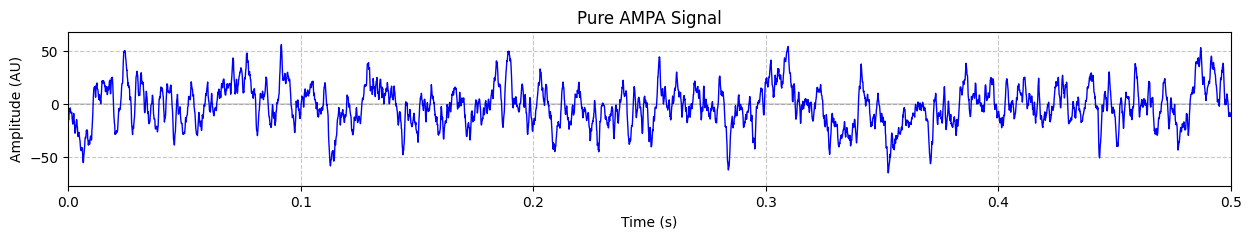

In [4]:
plot_trace(lfp_ampa, time_lfp_ampa, title = 'Pure AMPA Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'blue', linewidth = 1)

As expected, the $\Psi$ pattern recovers an excellent approximation of the AMPA synaptic kernel.

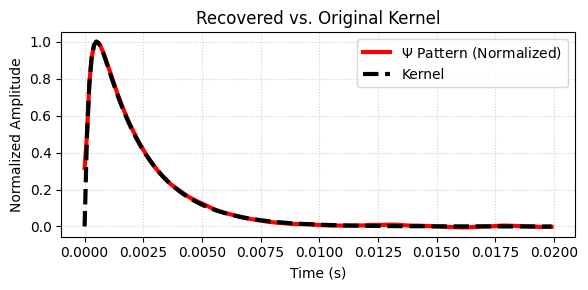

In [5]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.020 * fs)
kernel_ampa_seg, time_ker_ampa_seg = extract_segment(kernel_ampa, time_cut), extract_segment(time_ampa, time_cut)
psi_ampa_seg, time_psi_ampa_seg = extract_segment(psi_ampa, time_cut), extract_segment(time_psi_ampa, time_cut)

compare_kernel_normalized(kernel = kernel_ampa_seg, kernel_time = time_ker_ampa_seg, psi = psi_ampa_seg, psi_time = time_psi_ampa_seg)

In [6]:
# Error between recovered vs. original kernel
mae(kernel_ampa_seg, psi_ampa_seg)

Mean Absolute Error: 0.004384823035663805 (0.44%)


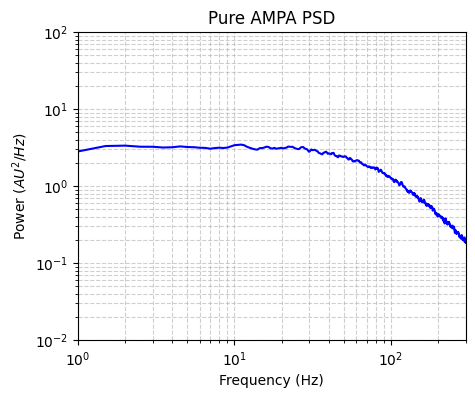

In [7]:
# PSD
plot_psd_log(psd = psd_ampa, freqs = freqs_ampa, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure AMPA PSD', color = 'blue')

##### **2. Pure GABAa Signal**

In [8]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (0, 0, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (5000, 50, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_gaba, _, _, time_lfp_gaba = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                     kernel_in = kernel_gaba, 
                                                     fs = fs, 
                                                     t_sec = t_sec, 
                                                     n_ex = n_ex, 
                                                     n_in = n_in, 
                                                     rate_ex = rate_ex, 
                                                     rate_in = rate_in,
                                                     w_ex = w_ex,
                                                     w_in = w_in)

# PSD 
psd_gaba, freqs_gaba = averaged_multitaper_psd(signal = lfp_gaba, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_gaba, time_psi_gaba = averaged_psi_pattern(signal = lfp_gaba, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

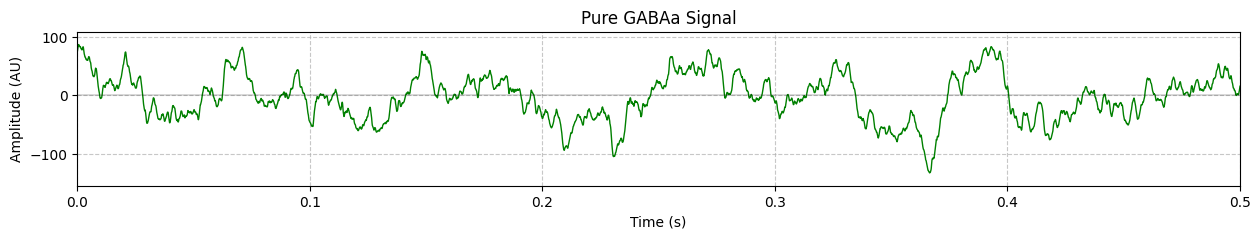

In [9]:
plot_trace(lfp_gaba, time_lfp_gaba, title = 'Pure GABAa Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'green', linewidth = 1)

Now the $\Psi$ pattern resembles de GABAa kernel.

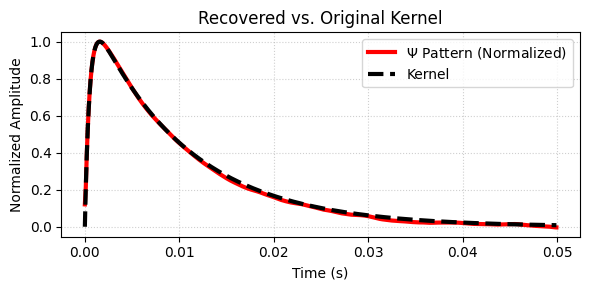

In [10]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.05 * fs)
kernel_gaba_seg, time_ker_gaba_seg = extract_segment(kernel_gaba, time_cut), extract_segment(time_gaba, time_cut)
psi_gaba_seg, time_psi_gaba_seg = extract_segment(psi_gaba, time_cut), extract_segment(time_psi_gaba, time_cut)

compare_kernel_normalized(kernel = kernel_gaba_seg, kernel_time = time_ker_gaba_seg, psi = psi_gaba_seg, psi_time = time_psi_gaba_seg)

In [11]:
# Error between recovered vs. original kernel
mae(kernel_gaba_seg, psi_gaba_seg)

Mean Absolute Error: 0.006355005533330662 (0.64%)


The pure GABAa PSD is also very different from the pure AMPA PSD.

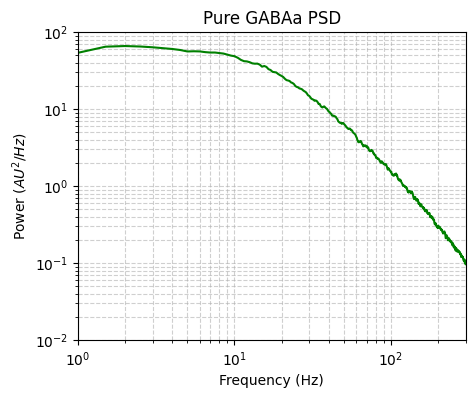

In [12]:
# PSD
plot_psd_log(psd = psd_gaba, freqs = freqs_gaba, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure GABAa PSD', color = 'green')

##### **3. AMPA/GABAa Signal (1:1 Ratio)**
Now, the signal will be composed of the superposition of both synaptic kernels. The number of neurons and the firing frequency for both AMPA and GABAa will be identical; therefore, the balance will be at a 1:1 ratio.

In [13]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (5000, 50, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (5000, 50, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_half, lfp_ex, lfp_in, time_lfp_half = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                               kernel_in = kernel_gaba, 
                                                               fs = fs, 
                                                               t_sec = t_sec, 
                                                               n_ex = n_ex, 
                                                               n_in = n_in, 
                                                               rate_ex = rate_ex, 
                                                               rate_in = rate_in,
                                                               w_ex = w_ex,
                                                               w_in = w_in)

# PSD 
psd_half, freqs_half = averaged_multitaper_psd(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_half, time_psi_half = averaged_psi_pattern(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

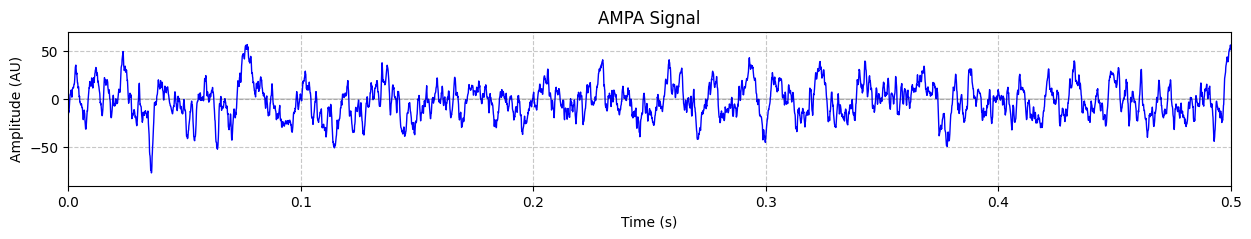

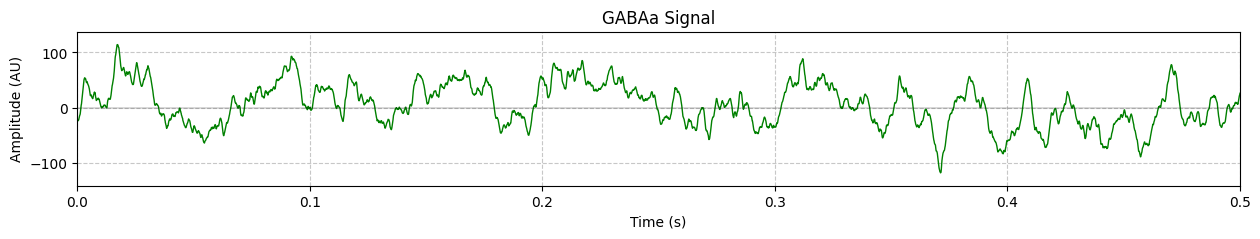

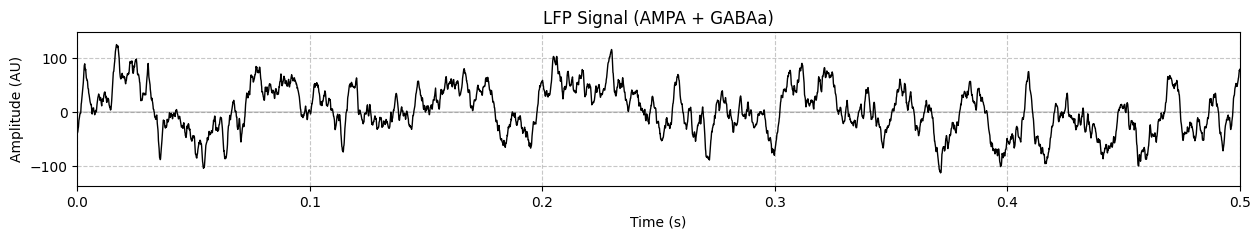

In [14]:
plot_trace(lfp_ex, time_lfp_half, title = 'AMPA Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'blue', linewidth = 1)
plot_trace(lfp_in, time_lfp_half, title = 'GABAa Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'green', linewidth = 1)
plot_trace(lfp_half, time_lfp_half, title = 'LFP Signal (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

We note that the $\Psi$ pattern is now not exactly identical to either the AMPA or GABAa synaptic kernels; instead, it corresponds to a sort of mixture (linear combination) of the two.

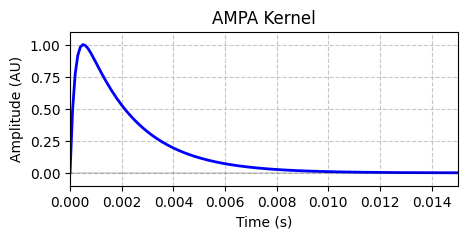

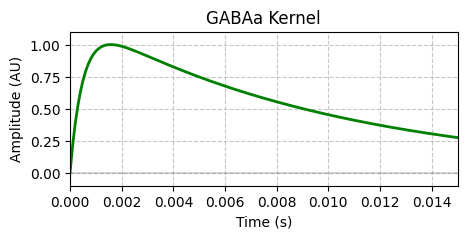

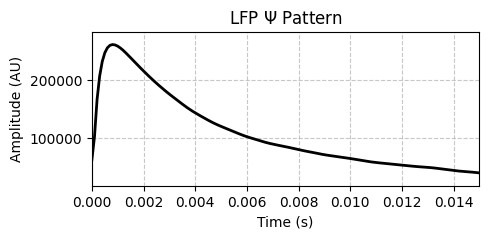

In [15]:
plot_trace(kernel_ampa, time_ampa, title = 'AMPA Kernel', xlim = (0, 0.015), trace_color = 'blue')
plot_trace(kernel_gaba, time_gaba, title = 'GABAa Kernel', xlim = (0, 0.015), trace_color = 'green')
plot_trace(psi_half, time_psi_half, title = 'LFP $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'black')

Something similar happens with the PSD.

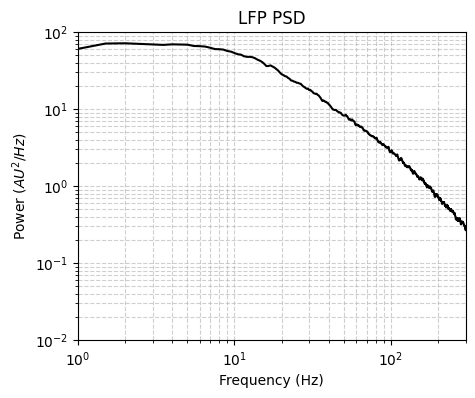

In [16]:
plot_psd_log(psd = psd_half, freqs = freqs_half, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'LFP PSD', color = 'black')

Finally, lets visualize the three $\Psi$ patterns together. We can easily see that the temporal profile of this pattern contains important information about the balance between excitatory (AMPA) and inhibitory (GABAa) events.

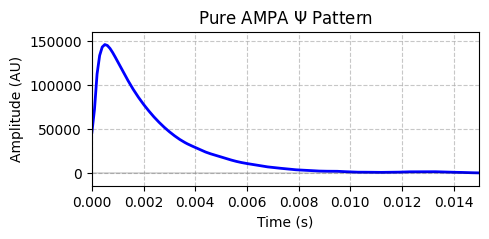

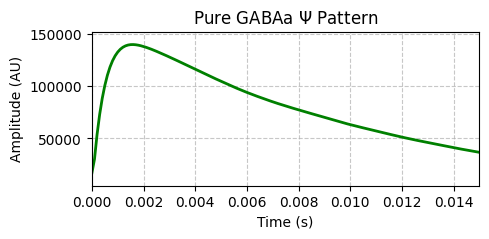

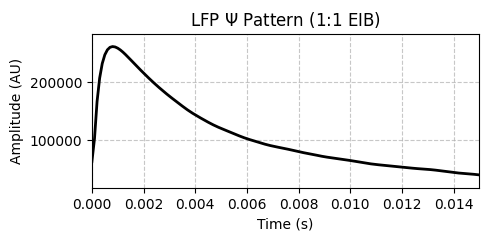

In [17]:
plot_trace(psi_ampa, time_psi_ampa, title = 'Pure AMPA $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'blue')
plot_trace(psi_gaba, time_psi_gaba, title = 'Pure GABAa $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'green')
plot_trace(psi_half, time_psi_half, title = 'LFP $\Psi$ Pattern (1:1 EIB)', xlim = (0, 0.015), trace_color = 'black')

---
##### **Quantifying the EIB**
We will now generate a large number of signals with varying EIB values (see *04_synaptic_balance.py*) to evaluate how the $\Psi$ pattern and spectral parameterization allow us to quantify changes in this balance. We will assess several quantification methods:

- The duration of the $\Psi$ pattern, defined as the time required for the pattern to decay to 15% of its maximum amplitude.
- The spectral slope in the 40 – 85 Hz band using specparam in 'fixed' mode.
- The spectral slope in the 1 – 300 Hz band using specparam in 'doublexp' mode.

In [24]:
# Importing the simulated data 
filename = r'C:\Users\marce\Escritorio\Proyectos\synaptic_lfp\simulation_results\eib_simulation_results.csv'
eib_data = pd.read_csv(filename, sep = ',')

print(eib_data.shape)
eib_data.head(5)

(5000, 14)


,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,offset_dexp,exp_0,knee,exp_1
0,0,1367,8633,0.158346,0.0200,0.0013,0.0187,268349.621609,4.163580,1.834767,4.989483,0.178913,707.392814,2.074132
1,1,149,9851,0.015125,0.0216,0.0016,0.0200,276229.242484,4.322688,1.904115,5.268648,0.282608,994.026203,2.102315
2,2,8420,1580,5.329114,0.0066,0.0006,0.0060,278009.220359,2.547716,1.045364,4.502486,0.283019,856.938944,1.698240
3,3,9683,317,30.545741,0.0048,0.0005,0.0043,287277.541037,2.108318,0.836488,5.027145,0.188474,7748.229134,1.995675
4,4,6470,3530,1.832861,0.0110,0.0007,0.0103,264110.233892,3.140238,1.341130,3.088439,-105.187034,27.162929,106.569289


In [25]:
eib_data.describe()

,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,offset_dexp,exp_0,knee,exp_1
count,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,5047.03340,4952.96660,11.164281,0.013229,0.000943,0.012287,274669.540526,3.317574,1.423869,4.550252,-16.870779,1794.908916,18.894239
std,1443.520003,3781.43341,3781.43341,21.186315,0.006727,0.000416,0.006329,9902.238349,0.911378,0.445561,0.813294,39.237141,2506.278277,38.937332
min,0.000000,99.00000,100.00000,0.009999,0.004500,0.000500,0.004000,256087.058764,1.680772,0.605117,1.915337,-123.488902,0.001753,-1.992228
25%,1249.750000,920.75000,927.25000,0.101413,0.005575,0.000500,0.005000,266151.921198,2.350217,0.953366,4.424847,0.122126,372.380246,1.872192
50%,2499.500000,5145.00000,4855.00000,1.059732,0.014500,0.000800,0.013700,275108.264812,3.516486,1.525627,4.831602,0.220065,843.368473,2.039641
75%,3749.250000,9072.75000,9079.25000,9.784599,0.020100,0.001400,0.018600,282778.385585,4.207437,1.852000,5.101572,0.264676,1245.496410,2.116127
max,4999.000000,9900.00000,9901.00000,99.000000,0.023700,0.001600,0.022100,292773.999287,4.659178,2.096819,5.372721,2.193676,12469.185183,124.440243


In [26]:
# We will transform time values from seconds to milliseconds 
cols = ['psi_duration', 'psi_rise', 'psi_decay']
eib_data[cols] = eib_data[cols] * 1000

eib_data.head(5)

,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,offset_dexp,exp_0,knee,exp_1
0,0,1367,8633,0.158346,20.0,1.3,18.7,268349.621609,4.163580,1.834767,4.989483,0.178913,707.392814,2.074132
1,1,149,9851,0.015125,21.6,1.6,20.0,276229.242484,4.322688,1.904115,5.268648,0.282608,994.026203,2.102315
2,2,8420,1580,5.329114,6.6,0.6,6.0,278009.220359,2.547716,1.045364,4.502486,0.283019,856.938944,1.698240
3,3,9683,317,30.545741,4.8,0.5,4.3,287277.541037,2.108318,0.836488,5.027145,0.188474,7748.229134,1.995675
4,4,6470,3530,1.832861,11.0,0.7,10.3,264110.233892,3.140238,1.341130,3.088439,-105.187034,27.162929,106.569289


##### **1. EIB and $\Psi$ Pattern Duration**

In [ ]:
# To do:
# Scatter plot
# Correlación spearman + significancia https://pingouin-stats.org/build/html/generated/pingouin.corr.html

##### **2. EIB and Spectral Parameterization (Fixed Mode in 40 - 85 Hz Frequency Range)**

In [ ]:
# To do:
# Scatter plot
# Correlación spearman + significancia https://pingouin-stats.org/build/html/generated/pingouin.corr.html

##### **3. EIB and Spectral Parameterization (Double Exponent Mode in 1 - 300 Hz Frequency Range)**

In [ ]:
# To do:
# Scatter plot
# Histograma y eliminar claros outliers
# Correlación spearman + significancia https://pingouin-stats.org/build/html/generated/pingouin.corr.html

In [ ]:
# Análisis estadístico? 

"""
La prueba Z de Steiger (o Steiger's Z-test) es un procedimiento estadístico utilizado para comparar la fuerza de dos correlaciones dependientes 
(es decir, que comparten una variable en común, como la correlación de A con B frente a la correlación de A con C) provenientes de la misma muestra, determinando 
si la diferencia entre ellas es estadísticamente significativa. 

"""